![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Modeling with Random Forests

In this Notebook we will show you how to do exploratory data and train a Random Forest Model. You will learn how to tune your Random Forest model to achieve the best performance.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/2025-HIDA-Spring/xai-for-random-forest/Gen-0-Tutorial_RandomForest_Model_Housing_Wine_Penguins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [8]:
# Mount drive folder to dbe abale to download repo
from google.colab import drive
drive.mount('/content/drive')

# Switch to correct folder'
%cd /content/drive/MyDrive

In [ ]:
# Don't run this cell if you already cloned the repo 
%rm -r XAI-Tutorials
!git clone --branch 2025-HIDA-Spring https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [ ]:
# Install al required dependencies and package versions
%cd XAI-Tutorials
!pip install -r requirements_xai-for-random-forest.txt
%cd xai-for-random-forest

### Imports

Let's start with importing all required Python packages.

In [11]:
# Load the required packages
import sys
import pickle
import numpy as np
import pandas as pd

from palmerpenguins import load_penguins

from sklearn.datasets import fetch_california_housing, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

sys.path.append('./')
import utils

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [12]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## The California Housing Dataset

In this notebook, we will work with the **California Housing dataset**, containing 20,640 median house values for California districts (expressed in $100,000), which are described by 8 numeric feature. Each row in the dataset represents a block of houses, not a single household. The data pertains to the house prices found in a given California district and some summary statistics about them based on the 1990 census data.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_california_housing.jpg?raw=true" width="900" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/datasets/harrywang/housing)

In [13]:
# Load the data
data_fetched = fetch_california_housing(as_frame=True)

We can have a look at the description of the dataset with `print(data_housing['DESCR'])`.  
Before we can start analysing the dataset, we have to retrieve the features and target variable.

In [14]:
# Get the dataframe
data_housing = data_fetched.frame

# Move target column to front
col_target = "MedHouseVal"
col_features = data_housing.columns.drop(col_target).to_list()
data_housing = data_housing[[col_target]+col_features]

### Exploratory Data Analysis

Exploratory data analysis is a first important step to get an understanding of the data and to identify patterns and problems in the data.  
First, we will check how many samples and variables our dataset has and inspect the first few lines of our dataset.

In [15]:
# Inspect the data
print(f"The dataset has {data_housing[col_features].shape[1]} features that describe {len(data_housing)} house blocks.")
print(f"We have {data_housing[col_features].select_dtypes(exclude='object').shape[1]} numerical and {data_housing[col_features].select_dtypes(include='object').shape[1]} categorical features.")

The dataset has 8 features that describe 20640 house blocks.
We have 8 numerical and 0 categorical features.


In [16]:
print("\nHere are the first few lines of our dataset:")
data_housing.head()


Here are the first few lines of our dataset:


,MedHouseVal,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,4.526,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,3.585,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,3.521,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,3.413,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.422,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Next, we check if any values are missing:

In [17]:
print(data_housing.isnull().sum())

MedHouseVal    0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
dtype: int64


And last, we inspect how our variables are distributed:

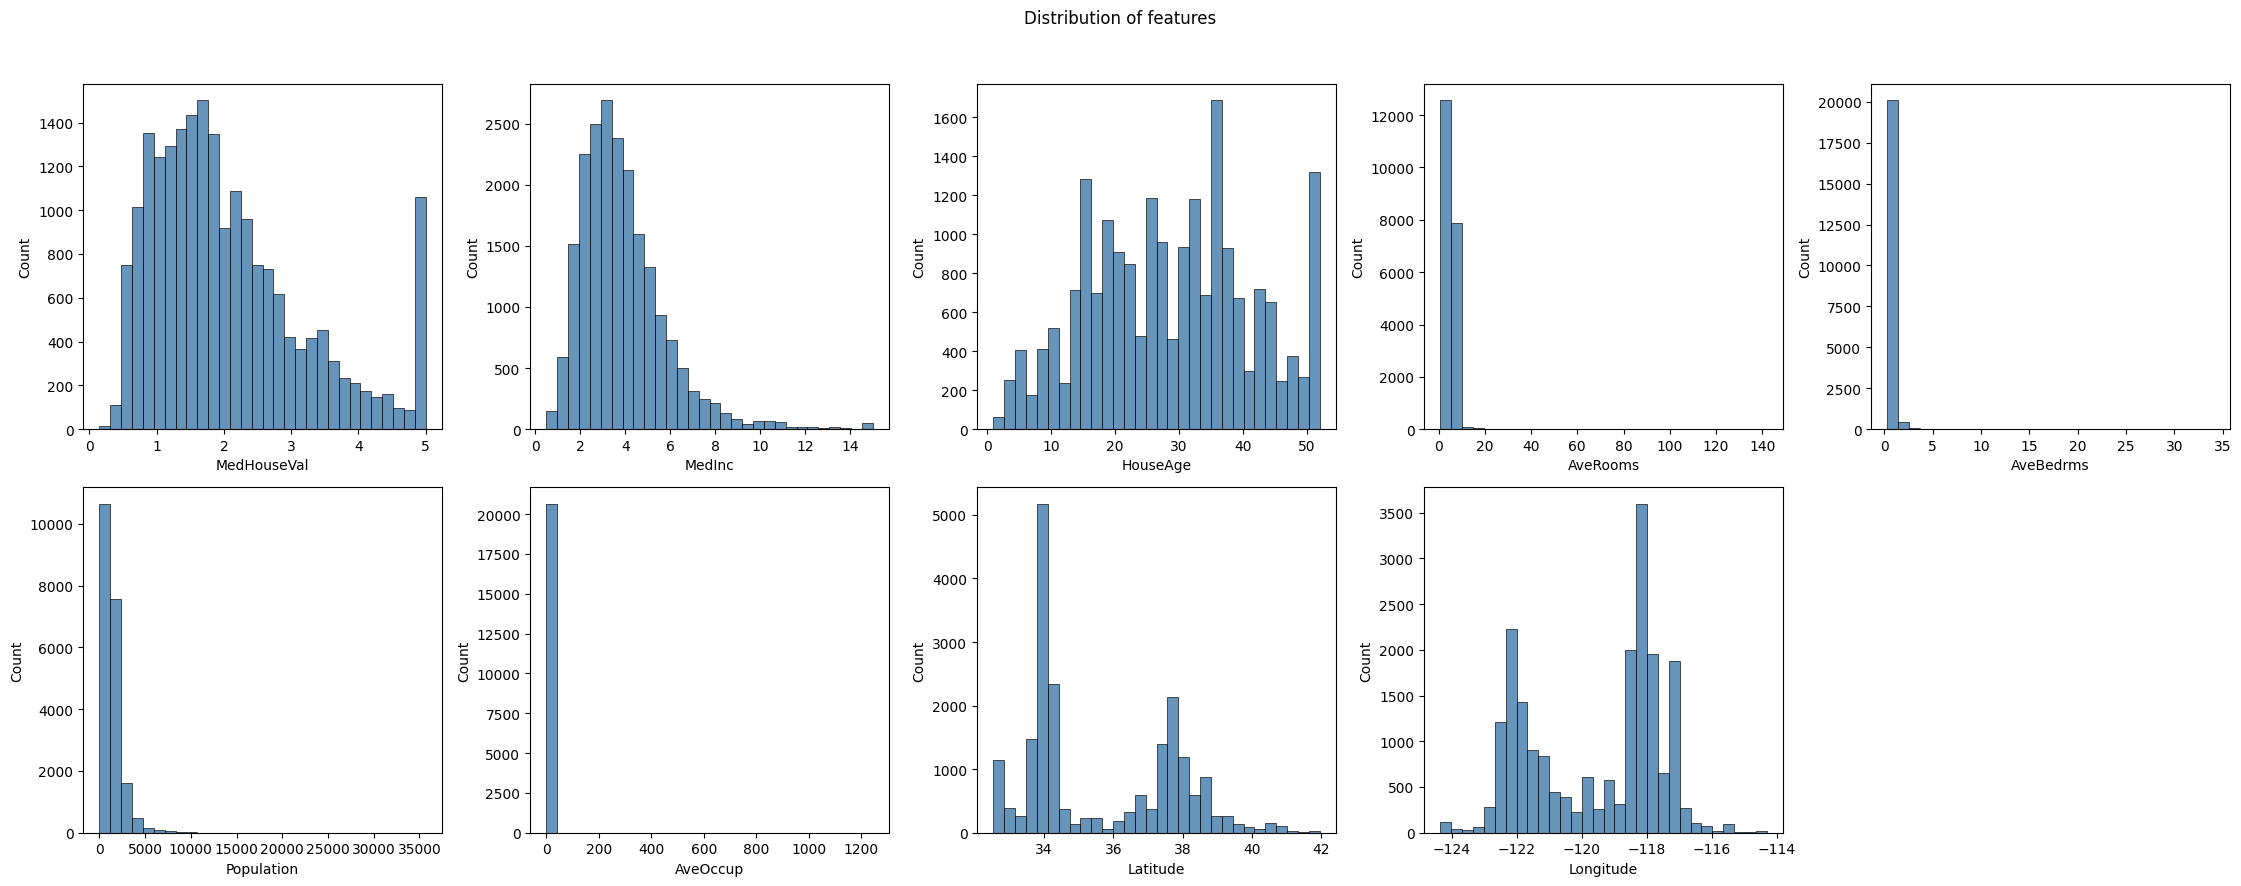

In [18]:
utils.plot_distributions(dataset=data_housing, ncols=5)

<font color='green'>

#### Question 1: What conclusions can be drawn from the exploratory data analysis?

<font color='grey'>

#### Your Answer: 

By analysing the results of the EDA we can conclude:

- we don't have missing values in the dataset we need to take care of
- we don't have categorical features that we need to encode for the classification model
- we don't have any extreme outliers

In [19]:
data = data_housing

# for sake of runtime we only use the first 1000 samples
data = data.iloc[:1000]

--------

## Random Forest Models

**Note: Please visit our [Introduction to Random Forest Models](https://xai-tutorials.readthedocs.io/en/latest/_ml_basics/random_forest.html) to get more theoretical background information on the Random Forest algorithm.**

In the subsequent sections we will show you how to train a Random Forest model for a binary classification problem. But before we start training our Random Forest model, try to answer the following questions:

<font color='green'>

#### Question 2: What are model hyperparameters and why do we have to tune them?

<font color='grey'>

#### Your Answer: 

While model parameters are learned during training — such as the slope and intercept in a linear regression — hyperparameters must be set by the data scientist before training. Hyperparameter tuning is essential for the overall performance of the machine learning model. The best hyperparameters are usually impossible to determine ahead of time, and tuning a model is where machine learning turns from a science into trial-and-error based engineering.

### Hyperparameters of Random Forest

The hyperparameters of the model are configured up-front and are provided by the caller of the model before the model is trained. They guide the learning process for a specific dataset and hence, they are very important for training a machine learning model. 

Some important hyperparameters for Random Forest models:

- `n_estimators` = number of trees in the model
- `criterion` = a function to measure the quality of the split
- `max_depth` = maximal depth of the tree (the longest path between the root node and the leaf node)
- `max_sample` = which fraction of the original dataset is given to each tree in the forest
- `max_features` = maximum number of features to consider when doing a split

The full list of hyperparemeters of the Random Forest models can be found in the scikit-learn documentation.

<font color='green'>

#### Question 3: How do we find the best hyperparameters?

<font color='grey'>

#### Your Answer: 

Hyperparameter tuning relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations evaluate the performance of each model. However, evaluating each model only on the training set can lead to one of the most fundamental problems in machine learning: overfitting. If we optimize the model for the training data, then our model will score very well on the training set, but will not be able to generalize to new data, such as in a test set. When a model performs highly on the training set but poorly on the test set, this is known as overfitting, or essentially creating a model that knows the training set very well but cannot be applied to new problems. An overfit model may look impressive on the training set, but will be useless in a real application. Therefore, the standard procedure for hyperparameter optimization accounts for overfitting through cross validation.

Now, that we learned about the hyperparameters of Random Forest and had a look at the choices we have for the Random Forest algorithm, it is time to choose the optimal hyperparameters for our model. We will objectively search through different values for Random Forest hyperparameters and choose the set of hyperparameters that results in the model with the best performance on a given validation set. To do this, we will define a search space as a grid of hyperparameter values and evaluate every position in the grid. This hyperparemter optimization technique is called **grid-search**. To evaluate the grid-search results, we can use **n-fold cross validation**. The n-fold cross validation strategy will split the training data into n folds and then train the model on n-1 folds and test it's performance on the nth fold, iterating through each fold as validation fold once. Hence, the reported score is the average score across n validation sets.

The grid-search technique searches through every combination of the hyperparameters you define. Hence, the run time can increase very fast and it should be something to take into account when training the model. For the sake of example, in this notebook we will define a rather small grids of hyperparameters.

--------

## Training a Random Forest Regressor

First, we will split the data into a **train and test set**, so the model does not use all the available information for training. That way, we can also check the performance on previously unseen data, mirroring the most probable practical use case.

In [20]:
# A Random Forest instance from sklearn requires a separate input of feature matrix and target values.
# Hence, we will first separate the target and feature columns.
X = data[col_features]
y = data[col_target]

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=seed)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(f'Number of training samples: {len(X_train.index)} samples.')
print(f'Number of training samples: {len(X_test.index)} samples.')

Number of training samples: 800 samples.
Number of training samples: 200 samples.


In addition, we need to standardize our features. This is not necessary for tree-based methods but required for other models, like linear regression or SVMs. To avoid information leakage between train and test set through the standardization procedure, we fit the Standardizer on the training set and use it to transform train and test set.

In [21]:
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Next, we define the hyperparameter grid we want to want to use for the grid-search. Feel free to change the grid based on your acquired knowledge and research on Random Forest hyperparameters! Just take care about the computation time for now. 


In [22]:
hyper_grid_classifier = {'n_estimators': [100, 1000], 
            'max_depth': [2, 5], 
            'max_samples': [0.8],
            'criterion': ['squared_error', 'poisson'],
            'max_features': ['sqrt','log2'],
            'bootstrap': [True]
}

Now we will start the training process. First, we define an instance of the `RandomForestRegressor`. Then, we run the `GridSearchCV` with the 5-fold cross validation using the grid we defined above. 

In [23]:
# Define a regressor. We set the oob_score = True, as OOB is a good approximation of the validation set score
regressor = RandomForestRegressor(oob_score=True, random_state=42, n_jobs=3)

# Define a grid search with 5-fold CV and fit 
gridsearch_regressor = GridSearchCV(regressor, hyper_grid_classifier, cv=5, verbose=1)
gridsearch_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_jobs=3, oob_score=True,
                                             random_state=42),
             param_grid={'bootstrap': [True],
                         'criterion': ['squared_error', 'poisson'],
                         'max_depth': [2, 5], 'max_features': ['sqrt', 'log2'],
                         'max_samples': [0.8], 'n_estimators': [100, 1000]},
             verbose=1)

Then we can check how well the best model performed during cross-validation and which hyperparameters lead to the best reults.

In [24]:
# Check the results
print(f'The mean cross-validated score of the best model is R^2 score of {round(gridsearch_regressor.best_score_, 2)} and the parameters of best prediction model are:')
print(gridsearch_regressor.best_params_)

The mean cross-validated score of the best model is R^2 score of 0.74 and the parameters of best prediction model are:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'max_samples': 0.8, 'n_estimators': 1000}


The model with the best hyperparameters is saved as the _best_estimator__ in the GridSearchCV instance.  
Note, that the returned model is a Random Forest Regressor that was refit using the best found parameters on the whole training dataset. 

We can estimate the training, validation and test score, using the training, OOB and test set, respectively.

In [25]:
# Take the best estimator
rf = gridsearch_regressor.best_estimator_

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train),2)} R^2 score.')

# is the model performing reasonably on the OOB data?
print(f'Model Performance on OOB data: {round(rf.oob_score_,2)} R^2 score.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test),2)} R^2 score.')

Model Performance on training data: 0.84 R^2 score.
Model Performance on OOB data: 0.74 R^2 score.
Model Performance on test data: 0.72 R^2 score.


Great, now you trained your Random Forest model! And it generalized with a good R^2!  

*Note: The $R^2$ is the coefficient of determination and the closer this value is to 1, the better our model explains the data. A constant model that always predicts the average target value disregarding the input features would get an $R^2$ score of 0. However, $R^2$ score can also be negative because the model can be arbitrarily worse.*

Let's now save the model in a ``pickle`` file, such that we can load the trained model into other notebooks later on.

In [26]:
# Save the model with joblib
data_and_model = [X_train, X_test, y_train, y_test, rf, scaler]

with open('../models/model_rf_housing.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

--------

## Extra Material: Training a Random Forest Model for Multiclass Classification

### Example 1: The Wine Recognition Dataset

In the first example, we will work with the **Wine Recognition dataset**, containing 178 wine samples from three different cultivators of wine in the same region in Italy. The wine was chemically analysed and 13 different chemical attributes like *alcohol*, *malic acid*, *flavanoids* etc were measured (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-recognition-dataset))

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_red_wine.jpg?raw=true" width="900" /></center>

<font size=1> Source:
[Link](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)

First, let's load the data and retrieve the features and target variable.

In [27]:
# Load the data
data_fetched = load_wine(as_frame=True)
data_wine = data_fetched.frame

# Move target column to front
col_target = "target"
col_features = data_wine.columns.drop(col_target).to_list()
data_wine = data_wine[[col_target]+col_features]
data_wine['target'] = data_wine['target'].map({0: 'type_1', 1: 'type_2', 2: 'type_3'})

#### Exploratory Data Analysis

Let's check how many samples and variables our dataset has and inspect the first few lines of our dataset:

In [28]:
# Inspect the data
print(f"The dataset has {data_wine[col_features].shape[1]} features that describe {len(data_wine)} house blocks.")
print(f"We have {data_wine[col_features].select_dtypes(exclude='object').shape[1]} numerical and {data_wine[col_features].select_dtypes(include='object').shape[1]} categorical features.")

The dataset has 13 features that describe 178 house blocks.
We have 13 numerical and 0 categorical features.


In [29]:
print("\nHere are the first few lines of our dataset:")
data_wine.head()


Here are the first few lines of our dataset:


,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,type_1,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,type_1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,type_1,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,type_1,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,type_1,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Next, we check if any values are missing:

In [30]:
print(data_wine.isnull().sum())

target                          0
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


And last, we inspect how our variables are distributed:

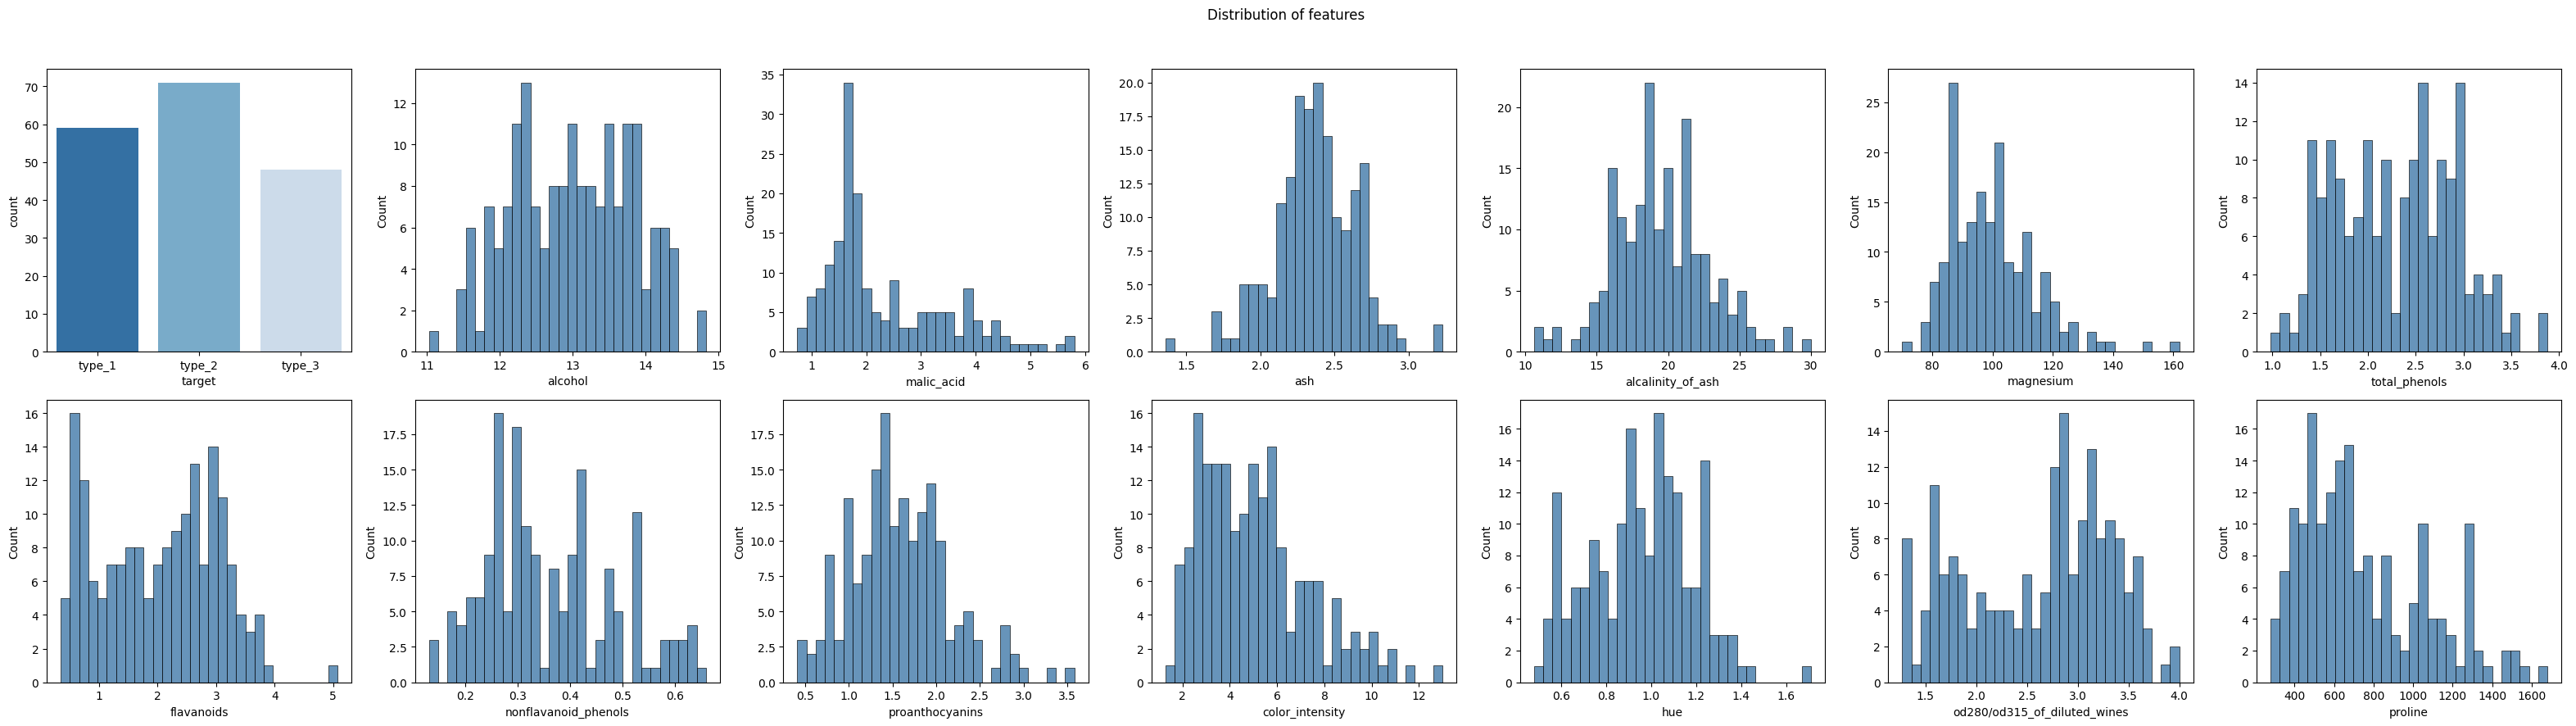

In [31]:
utils.plot_distributions(dataset=data_wine, ncols=7)

By analysing the results of the EDA we can conclude:

- the target variable is slightly imbalanced
- we don't have missing values in the dataset we need to take care of
- we don't have categorical features that we need to encode for the classification model
- we don't have any extreme outliers

In [32]:
data = data_wine

#### Training a Random Forest Model 

Let's now train our Random Forest model on the pre-processed dataset. As we have seen before, we need to split our data into a train and test set to be able to measure the generalizeability of our trained model. 

In [33]:
# A Random Forest instance from sklearn requires a separate input of feature matrix and target values.
# Hence, we will first separate the target and feature columns.
X = data[col_features]
y = data[col_target]

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=seed)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(f"Number of training samples: {len(X_train.index)} with {sum(y_train=='type_1')} class 0, {sum(y_train=='type_2')} class 1 and {sum(y_train=='type_3')} class 2 samples.")
print(f"Number of training samples: {len(X_test.index)} with {sum(y_test=='type_1')} class 0, {sum(y_test=='type_2')} class 1 and {sum(y_test=='type_3')} class 2 samples.")

Number of training samples: 142 with 45 class 0, 58 class 1 and 39 class 2 samples.
Number of training samples: 36 with 14 class 0, 13 class 1 and 9 class 2 samples.


In addition, we need to standardize our features.

In [34]:
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Next, we define the hyperparameter grid, we want to want to use for the grid-search and then start the training process with hyperparameter search.  

In [35]:
hyper_grid_classifier = {'n_estimators': [100, 1000], 
            'max_depth': [2, 5, 10], 
            'max_samples': [0.8],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt','log2']
}

# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=3)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, hyper_grid_classifier, cv=5, verbose=1)
gridsearch_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=3, oob_score=True,
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10],
                         'max_features': ['sqrt', 'log2'], 'max_samples': [0.8],
                         'n_estimators': [100, 1000]},
             verbose=1)

Let's now have a look at the training, validation and test accuracy.

In [36]:
# Take the best estimator
rf = gridsearch_classifier.best_estimator_

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train)*100,2)} % subset accuracy.')

# is the model performing reasonably on the OOB data?
print(f'Model Performance on OOB data: {round(rf.oob_score_*100,2)} % subset accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test)*100,2)} % subset accuracy.')

Model Performance on training data: 100.0 % subset accuracy.
Model Performance on OOB data: 99.3 % subset accuracy.
Model Performance on test data: 97.22 % subset accuracy.


Great, now you trained your Random Forest model! And it generalized with a high accuracy!  

Let's now save the model in a ``pickle`` file, such that we can load the trained model into other notebooks later on.

In [37]:
# Save the model with joblib
data_and_model = [X_train, X_test, y_train, y_test, rf, scaler]
with open('../models/model_rf_wine.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Example 2: The Penguins Dataset

For the second example, we will work with the **Palmer Penguins dataset**, containing the information on 3 different species of penguins - Adelie, Chinstrap, and Gentoo - which were observed in the Palmer Archipelago near Palmer Station, Antarctica. The dataset consist of a total of 344 penguings, together with their size measurements, clutch observations, and blood isotope ratios. 

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_penguins.png?raw=true" width="500" /></center>

<font size=1> Source: [Link](https://allisonhorst.github.io/palmerpenguins/)

First, let's load the data.

In [38]:
# Load the data
data_penguins = load_penguins()

# Move target column to front
col_target = "species"
col_features = data_penguins.columns.drop(col_target).to_list()
data_penguins = data_penguins[[col_target]+col_features]

#### Exploratory Data Analysis

Let's check how many samples and variables our dataset has and inspect the first few lines of our dataset:

In [39]:
# Inspect the data
print(f"The dataset has {data_penguins[col_features].shape[1]} features that describe {len(data_penguins)} house blocks.")
print(f"We have {data_penguins[col_features].select_dtypes(exclude='object').shape[1]} numerical and {data_penguins[col_features].select_dtypes(include='object').shape[1]} categorical features.")

The dataset has 7 features that describe 344 house blocks.
We have 5 numerical and 2 categorical features.


In [40]:
print("\nHere are the first few lines of our dataset:")
data_penguins.head()


Here are the first few lines of our dataset:


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Next, we check if any values are missing:

In [41]:
print(data_penguins.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64


And last, we inspect how our variables are distributed:

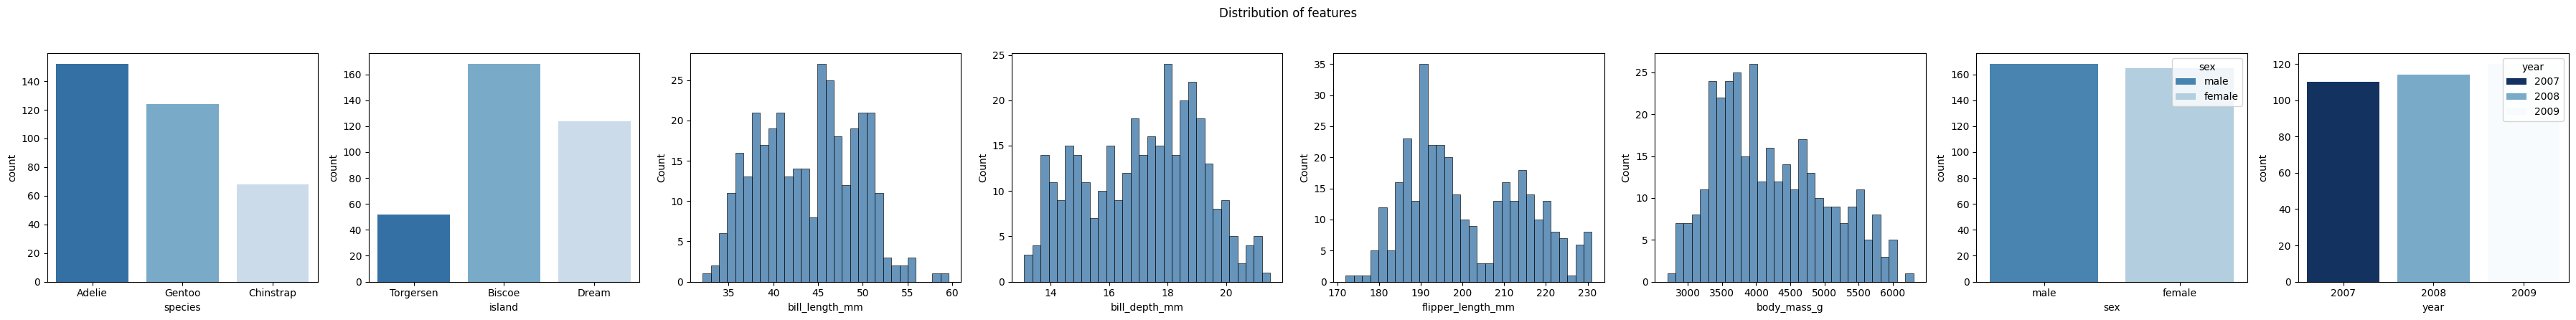

In [42]:
utils.plot_distributions(dataset=data_penguins, ncols=8)

By analysing the results of the EDA we can conclude:

- we have missing values in the dataset. There are different options how one can deal with this problem and the chosen strategy depends heavily on the dataset and the context we are in. We can, for example, just omit the cases with missing values (if we do not loose to many samples) or use a missing value imputation method
- we need to encode categorical features because sklearn models usually can't work with string values. These are the features 'island', 'sex', and the target variable 'species'. 

#### Data Preprocessing

**Handling of Missing Values**

Based on what we saw in the explorative analysis above, we need to do some preprocessing steps before we start training the model. First, we need to take care of the missing values. There are different options how one can deal with this problem and the strategy one chooses depends heavily on the dataset and the context we are in.

In this example, we will apply the most common approach and simply omit those cases with the missing data and analyse the remaining data. However, be careful with this technique - check how many instances we are left with after the step because the much lower sample number could hinder the training process and we would need to think about other ways to solve the problem, like applying missing data imputation strategies. 

In [43]:
# Remove the instances with missing values and check how many we are left with:
print(f"Before omiting the missing values the dataset has {data_penguins.shape[0]} instances")
data_penguins.dropna(inplace=True)
print(f"After omiting the missing values the dataset has {data_penguins.shape[0]} instances")

Before omiting the missing values the dataset has 344 instances
After omiting the missing values the dataset has 333 instances


The new sample size is fully acceptable for the next step. Is our dataset ready to be used for training the model?  
Well...almost! What did we observe regarding feature transformation? Do we need to encode some of them? Yes, we do! 

**Encoding of categorical variables**

Categorical features need to be encoded, i.e. turned into numerical data. This is essential because most machine learning models can only interpret numerical data and not data in a text form. As with many data preprocessing steps, there are multiple strategies one can apply to encode the categorical features. 

Here, we will use a simple **dummy encoding** for the categorical features, which will transform the categorical feature values into one-hot encoded vectors. Remeber that our goal is to predict the species of Palmer penguins and hence, our target variable *"Species"* does not need to be encoded, because it will be interepreted as different classes by the Random Forest Classifier.

In [44]:
# preprocess categorical features such that they can be used for the RF model
data_penguins_encoded = pd.get_dummies(data_penguins, columns=['island', 'sex'], prefix=['island', 'sex'], drop_first=True)
col_features = data_penguins_encoded.columns.drop(col_target).to_list()
data_penguins_encoded.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
0,Adelie,39.1,18.7,181.0,3750.0,2007,False,True,True
1,Adelie,39.5,17.4,186.0,3800.0,2007,False,True,False
2,Adelie,40.3,18.0,195.0,3250.0,2007,False,True,False
4,Adelie,36.7,19.3,193.0,3450.0,2007,False,True,False
5,Adelie,39.3,20.6,190.0,3650.0,2007,False,True,True


Note, that the option ``drop_first=True`` leads to k-1 dummies out of k categorical levels by removing the first level. However, it still contains the same amount of information. 

In [45]:
data = data_penguins_encoded

#### Training a Random Forest Model 

Let's now train our Random Forest model on the pre-processed dataset. As we have seen before, we need to split our data into a train and test set to be able to measure the generalizeability of our trained model. 

In [46]:
# A Random Forest instance from sklearn requires a separate input of feature matrix and target values.
# Hence, we will first separate the target and feature columns.
X = data[col_features]
y = data[col_target]

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=seed)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(f'Number of training samples: {len(X_train.index)} with {sum(y_train=="Adelie")} Adelie, {sum(y_train=="Chinstrap")} Chinstrap and {sum(y_train=="Gentoo")} Gentoo samples.')
print(f'Number of training samples: {len(X_test.index)} with {sum(y_test=="Adelie")} Adelie, {sum(y_test=="Chinstrap")} Chinstrap and {sum(y_test=="Gentoo")} Gentoo samples.')

Number of training samples: 266 with 118 Adelie, 55 Chinstrap and 93 Gentoo samples.
Number of training samples: 67 with 28 Adelie, 13 Chinstrap and 26 Gentoo samples.


In addition, we need to standardize our features.

In [47]:
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Next, we define the hyperparameter grid, we want to want to use for the grid-search and then start the training process with hyperparameter search.  

In [48]:
hyper_grid_classifier = {'n_estimators': [100, 1000], 
            'max_depth': [2, 5, 10], 
            'max_samples': [0.8],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt','log2']
}

# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=3)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, hyper_grid_classifier, cv=5, verbose=1)
gridsearch_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=3, oob_score=True,
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10],
                         'max_features': ['sqrt', 'log2'], 'max_samples': [0.8],
                         'n_estimators': [100, 1000]},
             verbose=1)

Let's now have a look at the training, validation and test accuracy.

In [49]:
# Take the best estimator
rf = gridsearch_classifier.best_estimator_

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train)*100,2)} % subset accuracy.')

# is the model performing reasonably on the OOB data?
print(f'Model Performance on OOB data: {round(rf.oob_score_*100,2)} % subset accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test)*100,2)} % subset accuracy.')

Model Performance on training data: 99.62 % subset accuracy.
Model Performance on OOB data: 98.87 % subset accuracy.
Model Performance on test data: 95.52 % subset accuracy.


Great, now you trained your Random Forest model! And it generalized with a high accuracy!  

Let's now save the model in a ``pickle`` file, such that we can load the trained model into other notebooks later on.

In [50]:
# Save the model with joblib
data_and_model = [X_train, X_test, y_train, y_test, rf, scaler]
with open('../models/model_rf_penguins.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)